# ins

In [ ]:
import copy
import random
import numpy as np

from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from transformers import CLIPTextModel, CLIPTokenizer, CLIPFeatureExtractor
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

class StableDiffuser(torch.nn.Module):
    def __init__(self):
        super().__init__()

        version = "CompVis/stable-diffusion-v1-4"
        self.vae = AutoencoderKL.from_pretrained(version, subfolder="vae")
        self.unet = UNet2DConditionModel.from_pretrained(version, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(version, subfolder="scheduler")
        self.safety_checker = StableDiffusionSafetyChecker.from_pretrained(version, subfolder="safety_checker")
        self.feature_extractor = CLIPFeatureExtractor.from_pretrained(version, subfolder="feature_extractor")

        version = "openai/clip-vit-large-patch14"
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.text_encoder = CLIPTextModel.from_pretrained(version)

        self.eval()
    
    def get_embd(self, prompt):
        token = self.tokenizer(prompt, padding="max_length", return_tensors="pt").input_ids
        embd = self.text_encoder(token.to(self.unet.device))[0]

        token = self.tokenizer([""], padding="max_length", return_tensors="pt").input_ids
        uncond_embd = self.text_encoder(token.to(self.unet.device))[0]
    
        return torch.cat([uncond_embd, embd])
    
    def set_scheduler_timesteps(self, step):
        self.scheduler.set_timesteps(step, device=self.unet.device)

    def get_initial_latent(self):
        noise = torch.randn((1, 4, 64, 64), dtype=self.unet.dtype, device=self.unet.device)
        latent = noise * self.scheduler.init_noise_sigma
        return latent

    def predict_noise(self, iteration, latent, embd, guidance_scale=7.5):
        latent = torch.cat([latent] * 2)
        latent = self.scheduler.scale_model_input(latent, self.scheduler.timesteps[iteration])
        noise = self.unet(latent, self.scheduler.timesteps[iteration], encoder_hidden_states=embd).sample
        uncond_noise, noise = noise.chunk(2)
        noise = uncond_noise + guidance_scale * (noise - uncond_noise)
        return noise

    def diffusion(self, latent, embd, end_iteration, guidance_scale=7.5):
        for iteration in range(0, end_iteration):
            noise = self.predict_noise(iteration, latent, embd, guidance_scale)
            output = self.scheduler.step(noise, self.scheduler.timesteps[iteration], latent)
            latent = output.prev_sample
        return latent

    def decode(self, latent):
        return self.vae.decode(1 / self.vae.config.scaling_factor * latent).sample

    def to_image(self, image):
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        return Image.fromarray(image)

    @torch.no_grad()
    def __call__(self, prompt):
        step = 50
        self.set_scheduler_timesteps(step)

        latent = self.get_initial_latent()
        embd = self.get_embd(prompt)

        latent = self.diffusion(latent, embd, step).to(self.unet.device)
        latent = self.decode(latent)
        image = self.to_image(latent)

        return image

def set_module(module, module_name, new_module):
    module_name = module_name.split('.')
    for name in module_name[:-1]:
        module = getattr(module, name)
    setattr(module, module_name[-1], new_module)

class FineTunedModel(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.model = model
        for parameter in self.model.parameters(): parameter.requires_grad = False
        
        self.ft_modules = {}
        self.orig_modules = {}
        for name, module in diffuser.named_modules():
            if "attn2" not in name or module.__class__.__name__ != "Linear": continue
            ft_module = copy.deepcopy(module)
            self.orig_modules[name] = module
            self.ft_modules[name] = ft_module
            for parameter in ft_module.parameters(): parameter.requires_grad = True
        self.ft_modules_list = torch.nn.ModuleList(self.ft_modules.values())
        self.orig_modules_list = torch.nn.ModuleList(self.orig_modules.values())
    
    def __enter__(self):
        for key, ft_module in self.ft_modules.items():
            set_module(self.model, key, ft_module)
    
    def __exit__(self, exc_type, exc_value, tb):
        for key, module in self.orig_modules.items():
            set_module(self.model, key, module)

In [ ]:
# erase_concept, erase_from
erase = [['Van Gogh', 'Van Gogh']]

lr = 2e-05
device = "cuda"
step = 50

diffuser = StableDiffuser().to(device)
diffuser.train()
finetuner = FineTunedModel(diffuser)
torch.cuda.empty_cache()

optimizer = torch.optim.Adam(finetuner.parameters(), lr=lr)
criteria = nn.MSELoss()

for i in range(200):
    with torch.no_grad():
        sampled_erase = erase[random.randint(0, len(erase)-1)]
        positive_embd = diffuser.get_embd([sampled_erase[0]])
        neutral_embd = diffuser.get_embd([""])
        target_embd = diffuser.get_embd([sampled_erase[1]])

        diffuser.set_scheduler_timesteps(step)

        latent = diffuser.get_initial_latent()
        iteration = random.randint(1, step-2)

        optimizer.zero_grad()
        with finetuner:
            latents_steps = diffuser.diffusion(latent, positive_embd, iteration)

        diffuser.set_scheduler_timesteps(1000)

        iteration = int(iteration / step * 1000)
        
        positive_latents = diffuser.predict_noise(iteration, latents_steps, positive_embd, guidance_scale=1)
        neutral_latents = diffuser.predict_noise(iteration, latents_steps, neutral_embd, guidance_scale=1)
        target_latents = diffuser.predict_noise(iteration, latents_steps, target_embd, guidance_scale=1)
        if sampled_erase[0] == sampled_erase[1]:
            target_latents = neutral_latents.clone().detach()
    with finetuner:
        negative_latents = diffuser.predict_noise(iteration, latents_steps, target_embd, guidance_scale=1)

    positive_latents.requires_grad = False
    neutral_latents.requires_grad = False
    

    loss = criteria(negative_latents, target_latents - (positive_latents - neutral_latents))
    
    loss.backward()
    optimizer.step()


del diffuser, loss, optimizer, finetuner, negative_latents, neutral_latents, positive_latents, latents_steps, latents

In [1]:
import copy
import random
import numpy as np

from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

class StableDiffuser(torch.nn.Module):
    def __init__(self):
        super().__init__()

        version = "CompVis/stable-diffusion-v1-4"
        self.vae = AutoencoderKL.from_pretrained(version, subfolder="vae")
        self.unet = UNet2DConditionModel.from_pretrained(version, subfolder="unet")
        self.scheduler = DDIMScheduler.from_pretrained(version, subfolder="scheduler")

        version = "openai/clip-vit-large-patch14"
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.text_encoder = CLIPTextModel.from_pretrained(version)

        self.eval()
    
    def get_embd(self, prompt):
        token = self.tokenizer(prompt, padding="max_length", return_tensors="pt").input_ids
        embd = self.text_encoder(token.to(self.unet.device))[0]

        token = self.tokenizer([""], padding="max_length", return_tensors="pt").input_ids
        uncond_embd = self.text_encoder(token.to(self.unet.device))[0]
    
        return torch.cat([uncond_embd, embd])
    
    def set_scheduler_timesteps(self, step):
        self.scheduler.set_timesteps(step, device=self.unet.device)

    def get_initial_latent(self):
        noise = torch.randn((1, 4, 64, 64), dtype=self.unet.dtype, device=self.unet.device)
        latent = noise * self.scheduler.init_noise_sigma
        return latent

    def predict_noise(self, iteration, latent, embd, guidance_scale=7.5):
        latent = torch.cat([latent] * 2)
        latent = self.scheduler.scale_model_input(latent, self.scheduler.timesteps[iteration])
        noise = self.unet(latent, self.scheduler.timesteps[iteration], encoder_hidden_states=embd).sample
        uncond_noise, noise = noise.chunk(2)
        noise = uncond_noise + guidance_scale * (noise - uncond_noise)
        return noise

    def diffusion(self, latent, embd, end_iteration, guidance_scale=7.5):
        for iteration in range(0, end_iteration):
            noise = self.predict_noise(iteration, latent, embd, guidance_scale)
            output = self.scheduler.step(noise, self.scheduler.timesteps[iteration], latent)
            latent = output.prev_sample
        return latent

    def decode(self, latent):
        return self.vae.decode(1 / self.vae.config.scaling_factor * latent).sample

    def to_image(self, image):
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        return Image.fromarray(image[0])

    @torch.no_grad()
    def __call__(self, prompt):
        step = 50
        self.set_scheduler_timesteps(step)

        latent = self.get_initial_latent()
        embd = self.get_embd(prompt)

        latent = self.diffusion(latent, embd, step).to(self.unet.device)
        latent = self.decode(latent)
        image = self.to_image(latent)

        return image

def set_module(module, module_name, new_module):
    module_name = module_name.split('.')
    for name in module_name[:-1]:
        module = getattr(module, name)
    setattr(module, module_name[-1], new_module)

class FineTunedModel(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.model = model
        for parameter in self.model.parameters(): parameter.requires_grad = False
        
        self.ft_modules = {}
        self.orig_modules = {}
        for name, module in diffuser.named_modules():
            if "attn2" not in name or module.__class__.__name__ != "Linear": continue
            ft_module = copy.deepcopy(module)
            self.orig_modules[name] = module
            self.ft_modules[name] = ft_module
            for parameter in ft_module.parameters(): parameter.requires_grad = True
        self.ft_modules_list = torch.nn.ModuleList(self.ft_modules.values())
        self.orig_modules_list = torch.nn.ModuleList(self.orig_modules.values())
    
    def __enter__(self):
        for key, ft_module in self.ft_modules.items():
            set_module(self.model, key, ft_module)
    
    def __exit__(self, exc_type, exc_value, tb):
        for key, module in self.orig_modules.items():
            set_module(self.model, key, module)

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\yoonj\anaconda3\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
erase = ['Van Gogh']

device = "cuda"
diffuser = StableDiffuser().to(device)
diffuser.train()
finetuner = FineTunedModel(diffuser)
torch.cuda.empty_cache()

lr = 2e-05
optimizer = torch.optim.Adam(finetuner.parameters(), lr=lr)
criteria = nn.MSELoss()

for i in range(200):
    with torch.no_grad():
        sampled_erase = erase[random.randint(0, len(erase)-1)]
        positive_embd = diffuser.get_embd([sampled_erase])
        neutral_embd = diffuser.get_embd([""])

        step = 50
        diffuser.set_scheduler_timesteps(step)
        iteration = random.randint(1, step-2)

        latent = diffuser.get_initial_latent()

        optimizer.zero_grad()

        with finetuner:
            latent = diffuser.diffusion(latent, positive_embd, iteration, 3.0)

        diffuser.set_scheduler_timesteps(1000)
        iteration = int(iteration / step * 1000)
        
        positive_latent = diffuser.predict_noise(iteration, latent, positive_embd, 1.0)
        neutral_latent = diffuser.predict_noise(iteration, latent, neutral_embd, 1.0)
    
    positive_latent.requires_grad = False
    neutral_latent.requires_grad = False
    
    with finetuner:
        negative_latent = diffuser.predict_noise(iteration, latent, positive_embd, 1.0)

    loss = criteria(negative_latent, neutral_latent - (positive_latent - neutral_latent))
    
    loss.backward()
    optimizer.step()

    print(f"Iteration {i:3d}: {loss.item():.3f}")

del optimizer, positive_embd, neutral_embd, latent, positive_latent, neutral_latent, negative_latent, loss

Iteration   0: 0.004
Iteration   1: 0.005
Iteration   2: 0.063
Iteration   3: 0.003
Iteration   4: 0.000
Iteration   5: 0.001
Iteration   6: 0.004
Iteration   7: 0.000
Iteration   8: 0.001
Iteration   9: 0.002
Iteration  10: 0.001
Iteration  11: 0.002
Iteration  12: 0.003
Iteration  13: 0.001
Iteration  14: 0.001
Iteration  15: 0.001
Iteration  16: 0.002


KeyboardInterrupt: 

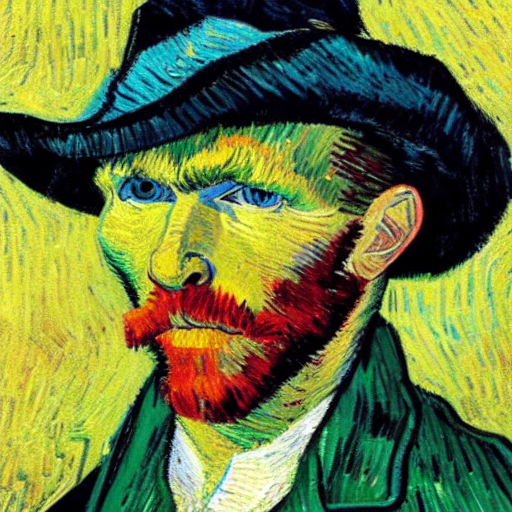

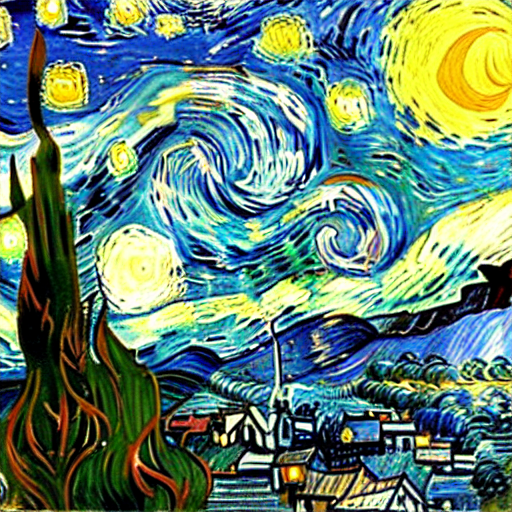

In [6]:
prompt = ['An image in the style of Vincent Van Gogh']
display(diffuser(prompt))
with finetuner:
    display(diffuser(prompt))